In [47]:
from typing import Annotated,Literal,Sequence,TypedDict
from langchain import hub
from langchain_core.messages import BaseMessage,HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel,Field
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from langgraph.graph import END,StateGraph,START
from langgraph.prebuilt import ToolNode

In [48]:
from langchain_huggingface import HuggingFaceEmbeddings

In [49]:
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [50]:
from langchain_groq import ChatGroq

In [51]:
llm=ChatGroq(model_name="Gemma2-9b-It")

In [52]:
llm.invoke("hi hello how are you?")

AIMessage(content="As an AI, I don't have feelings, but I'm here and ready to assist you! How can I help you today? 😊\n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 15, 'total_tokens': 48, 'completion_time': 0.06, 'prompt_time': 8.8569e-05, 'queue_time': 0.02262318, 'total_time': 0.060088569}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-ae5bc1f3-3cab-4fd8-88ec-a967254e05cb-0', usage_metadata={'input_tokens': 15, 'output_tokens': 33, 'total_tokens': 48})

In [67]:
urls = [
   "https://www.langchain.com/stateofaiagents",
   "https://langchain-ai.github.io/langgraph/tutorials/introduction/"
]

In [68]:
docs=[WebBaseLoader(url).load() for url in urls]

In [69]:
docs

[[Document(metadata={'source': 'https://www.langchain.com/stateofaiagents', 'title': 'LangChain State of AI Agents Report', 'description': "Are AI agents being used in production? What's the biggest challenge to deploying agents - cost, quality, skill, or latency? Get insights on AI agent adoption and sentiment for devs and enterprises today.", 'language': 'en'}, page_content='LangChain State of AI Agents Report\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nProducts\n\nLangChainLangSmithLangGraphMethods\n\nRetrievalAgentsEvaluationResources\n\nBlogCustomer StoriesLangChain AcademyCommunityExpertsChangelogLLM Evaluations GuideState of AI AgentsBreakout Agent StoriesDocs\n\nPythonLangChainLangSmithLangGraphJavaScriptLangChainLangSmithLangGraphCompany\n\nAboutCareersPricing\n\nLangSmithLangGraph PlatformGet a demoSign up\n\n\n\nState of AI AgentsWe surveyed over 1,300 professionals — from engineers and product managers to business leaders and executives — to uncover the state of AI agent

In [70]:
docs[0][0].metadata

{'source': 'https://www.langchain.com/stateofaiagents',
 'title': 'LangChain State of AI Agents Report',
 'description': "Are AI agents being used in production? What's the biggest challenge to deploying agents - cost, quality, skill, or latency? Get insights on AI agent adoption and sentiment for devs and enterprises today.",
 'language': 'en'}

In [71]:
docs[1][0].metadata

{'source': 'https://langchain-ai.github.io/langgraph/tutorials/introduction/',
 'title': 'Learn the basics',
 'description': 'Build language agents as graphs',
 'language': 'en'}

In [72]:
docs_list = [item for sublist in docs for item in sublist]

In [73]:
docs_list

[Document(metadata={'source': 'https://www.langchain.com/stateofaiagents', 'title': 'LangChain State of AI Agents Report', 'description': "Are AI agents being used in production? What's the biggest challenge to deploying agents - cost, quality, skill, or latency? Get insights on AI agent adoption and sentiment for devs and enterprises today.", 'language': 'en'}, page_content='LangChain State of AI Agents Report\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nProducts\n\nLangChainLangSmithLangGraphMethods\n\nRetrievalAgentsEvaluationResources\n\nBlogCustomer StoriesLangChain AcademyCommunityExpertsChangelogLLM Evaluations GuideState of AI AgentsBreakout Agent StoriesDocs\n\nPythonLangChainLangSmithLangGraphJavaScriptLangChainLangSmithLangGraphCompany\n\nAboutCareersPricing\n\nLangSmithLangGraph PlatformGet a demoSign up\n\n\n\nState of AI AgentsWe surveyed over 1,300 professionals — from engineers and product managers to business leaders and executives — to uncover the state of AI agents

In [ ]:
text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=100, chunk_overlap=5)

In [ ]:
doc_splits=text_splitter.split_documents(docs_list)

In [78]:
doc_splits

[Document(metadata={'source': 'https://www.langchain.com/stateofaiagents', 'title': 'LangChain State of AI Agents Report', 'description': "Are AI agents being used in production? What's the biggest challenge to deploying agents - cost, quality, skill, or latency? Get insights on AI agent adoption and sentiment for devs and enterprises today.", 'language': 'en'}, page_content='LangChain State of AI Agents Report\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nProducts\n\nLangChainLangSmithLangGraphMethods\n\nRetrievalAgentsEvaluationResources\n\nBlogCustomer StoriesLangChain AcademyCommunityExpertsChangelogLLM Evaluations GuideState of AI AgentsBreakout Agent StoriesDocs\n\nPythonLangChainLangSmithLangGraphJavaScriptLangChainLangSmithLangGraphCompany'),
 Document(metadata={'source': 'https://www.langchain.com/stateofaiagents', 'title': 'LangChain State of AI Agents Report', 'description': "Are AI agents being used in production? What's the biggest challenge to deploying agents - cost, qu

In [79]:
vectorstore=Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chrome",
    embedding=embeddings
)

In [80]:
retriever=vectorstore.as_retriever()

In [81]:
retriever_tool = create_retriever_tool(
    retriever,
    "retriever_ai_agents_report",
    "Are AI agents being used in production? What's the biggest challenge to deploying agents - cost, quality, skill, or latency? Get insights on AI agent adoption and sentiment for devs and enterprises today.",
)

In [82]:
tools=[retriever_tool]

In [88]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [90]:
class grade(BaseModel):
    binary_score: str = Field(description="Relevance score 'yes' or 'no'")

In [91]:
def AI_Assistant(state:AgentState):
    print("---CALL AGENT---")
    messages = state['messages']
    llm_with_tool = llm.bind_tools(tools)
    response = llm_with_tool.invoke(messages)
    return {"messages":[response]}
    

In [143]:
retrieve=ToolNode([retriever_tool])

In [144]:
def grade_documents(state:AgentState)->Literal["Output_Generator", "Query_Rewriter"]:
    llm_with_structure_op=llm.with_structured_output(grade)
    
    prompt=PromptTemplate(
        template="""You are a grader deciding if a document is relevant to a user’s question.
                    Here is the document: {context}
                    Here is the user’s question: {question}
                    If the document talks about or contains information related to the user’s question, mark it as relevant. 
                    Give a 'yes' or 'no' answer to show if the document is relevant to the question.""",
                    input_variables=["context", "question"]
                    )
    chain = prompt | llm_with_structure_op
    
    messages = state["messages"]
    print(f"message from the grader: {messages}")
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content
    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generator" #this should be a node name
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewriter" #this should be a node name

In [92]:
def generate(state:AgentState):
    print("---GENERATE---")
    messages = state["messages"]
    
    print(f"here is message from generate: {messages}")
    
    question = messages[0].content
    last_message = messages[-1]
    docs = last_message.content
    
    prompt = hub.pull("rlm/rag-prompt")
    
    rag_chain = prompt | llm

    response = rag_chain.invoke({"context": docs, "question": question})
    print(f"this is my response:{response}")
    
    return {"messages": [response]}

In [94]:
from langchain_core.messages import  HumanMessage
def rewrite(state:AgentState):
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content
    
    print(f"here is message from rewrite: {messages}")
    
    message = [HumanMessage(content=f"""Look at the input and try to reason about the underlying semantic intent or meaning. 
                    Here is the initial question: {question} 
                    Formulate an improved question: """)
       ]
    response = llm.invoke(message)
    return {"messages": [response]}

In [136]:
graph=StateGraph(AgentState)
graph.add_node("ai_assistant",AI_Assistant)
graph.add_node("retriever",retrieve)
graph.add_node("rewriter",rewrite)
graph.add_node("generator",generate)

In [137]:
graph.add_edge(START,"ai_assistant")
graph.add_conditional_edges("ai_assistant",
                               tools_condition,
                               {"tools": "retriever",
                                END: END,})

In [138]:
graph.add_conditional_edges("retriever",
                            grade_documents,
                            {"generator": "generator",
                            "rewriter": "rewriter"
                            }
                            )

In [139]:
graph.add_edge("generator", END)

In [140]:
graph.add_edge("rewriter", "ai_assistant")

In [141]:
app=graph.compile()

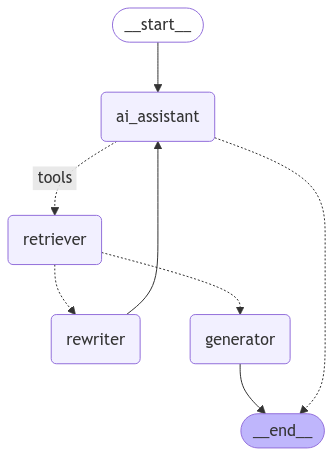

In [142]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [145]:
app.invoke({"messages":["What is a Autonomous Agent?"]})

---CALL AGENT---
message from the grader: [HumanMessage(content='What is a Autonomous Agent?', additional_kwargs={}, response_metadata={}, id='c950bdb0-b9fa-4394-9549-685d401fb3d0'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_vze0', 'function': {'arguments': '{"query":"What is an autonomous agent?"}', 'name': 'retriever_ai_agents_report'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 91, 'prompt_tokens': 997, 'total_tokens': 1088, 'completion_time': 0.165454545, 'prompt_time': 0.03185468, 'queue_time': 0.021621268, 'total_time': 0.197309225}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f18a076d-c4db-4ff2-b42c-aead9d4c19f0-0', tool_calls=[{'name': 'retriever_ai_agents_report', 'args': {'query': 'What is an autonomous agent?'}, 'id': 'call_vze0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 997, 'output_tokens': 91, 'total_tokens': 1088}

c:\Users\kuheli dey\anaconda3\New folder\anacoda\envs\langgraph\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


this is my response:content='An autonomous agent is a system that uses a large language model (LLM) to control the flow of an application.  It operates on a spectrum of autonomy, similar to autonomous vehicles.  Think of it as a program that can make decisions and take actions based on the information it receives from the LLM. \n\n\n' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 67, 'prompt_tokens': 295, 'total_tokens': 362, 'completion_time': 0.121818182, 'prompt_time': 0.009037752, 'queue_time': 0.024966326, 'total_time': 0.130855934}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None} id='run-f34e2f87-fd00-4f6f-bfb8-ff48038d4a6d-0' usage_metadata={'input_tokens': 295, 'output_tokens': 67, 'total_tokens': 362}


{'messages': [HumanMessage(content='What is a Autonomous Agent?', additional_kwargs={}, response_metadata={}, id='c950bdb0-b9fa-4394-9549-685d401fb3d0'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_vze0', 'function': {'arguments': '{"query":"What is an autonomous agent?"}', 'name': 'retriever_ai_agents_report'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 91, 'prompt_tokens': 997, 'total_tokens': 1088, 'completion_time': 0.165454545, 'prompt_time': 0.03185468, 'queue_time': 0.021621268, 'total_time': 0.197309225}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f18a076d-c4db-4ff2-b42c-aead9d4c19f0-0', tool_calls=[{'name': 'retriever_ai_agents_report', 'args': {'query': 'What is an autonomous agent?'}, 'id': 'call_vze0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 997, 'output_tokens': 91, 'total_tokens': 1088}),
  ToolMessage(content="B

In [146]:
prompt = hub.pull("rlm/rag-prompt")

c:\Users\kuheli dey\anaconda3\New folder\anacoda\envs\langgraph\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [148]:
prompt.pretty_print()

================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:
